### 데이터 준비 - tpcc

In [89]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from smac import HyperparameterOptimizationFacade, Scenario
from ConfigSpace import Configuration, ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter

In [306]:
### RANDOM WORKLOAD AND SAMPLE
import random
import glob
import os
import sys
import pandas as pd


knob_list = glob.glob("/home/sein/2023_EDBT/KCC_tpcc_dataset/knobs/my_*.cnf")
metrics = pd.read_csv("/home/sein/2023_EDBT/KCC_tpcc_dataset/external_metrics/external_metrics.csv")

# df_1 = df.drop([0, 3], axis = 0)

metrics = metrics.drop(['Unnamed: 0'], axis = 1)
# metrics = pd.DataFrame(metrics)


In [269]:
# drop_df = metrics.drop(metrics.index[100:131], inplace=True)
# labels=range(40, 45), axis=0

In [307]:
###전체 샘플에 대한 config num = 200

conf_best_cluster = []
cnt = 0

for xx in range(len(knob_list)):
    path = "/home/sein/2023_EDBT/KCC_tpcc_dataset/knobs/my_{}.cnf".format(xx)
    # knob_list = glob.glob("/home/sein/2023_EDBT/KCC_tpcc_dataset/my_*.cnf")
    a_all = pd.read_csv(path, sep="=", names=['Sample', 'value'], header=2)
    a_all = a_all.set_index("Sample")
    cur_all_df = a_all.T
    
    if cnt == 0:
        concat_all_df = cur_all_df
    else :
        concat_all_df = pd.concat([concat_all_df, cur_all_df], axis=0)
    cnt += 1
concat_all_df = concat_all_df.reset_index()
concat_all_df = concat_all_df.drop(["index"],axis=1)
concat_all_df = concat_all_df.drop(concat_all_df.columns[[0,1]], axis=1)


concat_all_df

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,1,62397,28761260,902096,218611,1,57330092,40673350,6,23,...,155252,582346,398494,448496,55,8912,38596832,71244,127749,1
1,0,61126,12323469,372360,902744,1,55248077,32173509,1,8,...,270871,681717,25103,117131,14,3606,44986708,91182,121301,0
2,1,63882,877563,556226,562000,0,22531059,8844641,2,29,...,144552,238441,140390,210891,35,3936,5108973,108383,120315,1
3,0,53648,44989860,643829,240604,0,51126596,64620967,4,6,...,101159,271032,51398,67088,58,15186,29885109,102217,72229,0
4,0,36554,34157311,603791,861616,1,17212731,53372825,2,25,...,339886,282910,96347,436044,42,963,57867331,129812,37554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0,35224,33846181,570867,174207,1,14643989,4707760,1,21,...,336437,981052,179359,41535,6,2773,42032000,84397,37247,1
196,0,43594,46764012,959258,465348,0,20400252,43326817,4,10,...,296167,876566,14933,443139,3,14670,17431815,124522,13370,0
197,1,31169,12998529,133561,594845,0,1372100,27345220,2,13,...,445383,27353,455555,502474,2,16289,11619666,113172,7410,1
198,1,22642,66731083,153340,597011,1,7226444,66535736,5,16,...,264524,328814,114388,398463,49,2815,40215982,116870,102320,0


### 전체 데이터 (#200 / 139개 knob)에 대한 실험

In [331]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



### 전체 config에서 성능이 좋은 config 10개 고르기

In [315]:
### TPS / LATENCY TOP 10

metrics['score'] = metrics['tps'] / metrics['latency']

metric_list_sorting = metrics.sort_values('score', ascending=False)

best_config_perform = metric_list_sorting.head(10)
best_config_perform
# random_metric_list.head(10)

,tps,latency,score
162,494.978937,11761,0.042086
110,478.244428,12129,0.039430
113,470.176574,12221,0.038473
91,446.815280,13151,0.033976
97,442.744854,13185,0.033579
71,417.011060,14406,0.028947
194,447.560396,15865,0.028211
171,413.110545,15601,0.026480
101,430.565757,16450,0.026174
85,391.881830,15401,0.025445


In [316]:
### 성능 좋은 10개 config

best_config_perform_idx = best_config_perform.index
best_config = []
for j in range(len(best_config_perform_idx)):
    n_knobs = pd.read_table("/home/sein/2023_EDBT/KCC_tpcc_dataset/knobs/my_{}.cnf".format(best_config_perform_idx[j]))
    best_config.append(n_knobs)

In [317]:
### best config 10개에 대한 dataframe (knob은 그대로)
cnt = 0

best_config_perform_idx = best_config_perform.index
best_config = []
for j in range(len(best_config_perform_idx)):
    path = "/home/sein/2023_EDBT/KCC_tpcc_dataset/knobs/my_{}.cnf".format(best_config_perform_idx[j])
    best_all = pd.read_csv(path, sep="=", names=['Sample', 'value'], header=2)
    best_all = best_all.set_index("Sample")
    cur_best_all = best_all.T
    
    if cnt == 0:
        best_all_df = cur_best_all
    else :
        best_all_df = pd.concat([best_all_df, cur_best_all], axis=0)
    cnt += 1
best_all_df = best_all_df.reset_index()
best_all_df = best_all_df.drop(["index"],axis=1)
best_all_df_ = best_all_df.drop([best_all_df.columns[0],best_all_df.columns[1]], axis=1)
best_all_df = best_all_df_
best_all_df

    

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,1,24081,24452507,899994,350041,1,10125942,33831653,4,20,...,316937,737036,362547,319755,38,9115,1836772,31869,21126,0
1,1,12873,11232981,324335,140652,0,61408314,31445243,3,1,...,485873,104387,189965,108679,38,11788,32325563,29950,35565,0
2,0,37399,36521299,67483,396271,1,42458892,38043123,1,9,...,407549,841553,514277,207178,3,328,25348284,56309,3319,0
3,1,24563,10415286,786686,164622,1,55691653,55282145,3,5,...,258524,539612,485648,283409,40,5267,16745966,23236,92877,0
4,1,55312,37600239,63121,987717,0,31856014,34621987,5,7,...,291659,642389,292260,118135,15,10276,50485477,107437,19453,1
5,1,33680,58274549,52095,274278,1,51651323,22350691,5,5,...,304675,85814,155757,83269,62,13831,40346533,71588,129478,1
6,0,49189,7960277,233457,91307,1,64034709,56371787,6,0,...,519523,898866,273001,84861,25,3217,17489968,81549,13975,1
7,1,82,13404455,537590,279897,1,65929906,61119562,5,5,...,219512,321973,172051,55878,7,15848,60171673,49740,109384,1
8,1,20689,25624394,686859,474921,0,17511604,18599099,6,11,...,140055,286542,457481,465873,27,16050,40656492,35755,130096,1
9,1,17355,21515954,658560,64234,1,2992528,26206848,7,14,...,19443,403898,250855,397343,26,11294,52141047,97684,96830,0


In [318]:
###XGBRegressor top 10 config 데이터에 대해서

### X_top // top 10 config
### Y_top // top 10 performance

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_top = np.array(best_all_df)
Y_top = np.array(best_config_perform[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_top)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_top)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



In [319]:
best_config_perform

,tps,latency,score
162,494.978937,11761,0.042086
110,478.244428,12129,0.039430
113,470.176574,12221,0.038473
91,446.815280,13151,0.033976
97,442.744854,13185,0.033579
71,417.011060,14406,0.028947
194,447.560396,15865,0.028211
171,413.110545,15601,0.026480
101,430.565757,16450,0.026174
85,391.881830,15401,0.025445


In [144]:
best_all_df.columns[0]

'automatic_sp_privileges '

### Top-K knob 구하기 by SHAP VALUE

In [285]:
#####Shap_value

###XGBRegressor

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.3, shuffle=True)
X_scaler = MinMaxScaler().fit(X_train)
Y_scaler = MinMaxScaler().fit(y_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
scaled_y_train = Y_scaler.transform(y_train)
scaled_y_test = Y_scaler.transform(y_test)

# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)

estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model_pred = MultiOutputRegressor(estimator = estimator).fit(scaled_X_train, scaled_y_train)


pred = my_model_pred.predict(scaled_X_test)

#rmse
print('RMSE : ',mean_squared_error(scaled_y_test, pred, squared=False))
print('R2_SCORE : ', r2_score(scaled_y_test, pred))
# print('PCC : ', precision_score(y_test, pred, average='weighted'))

# rmse r2 pcc




RMSE :  0.17957260667079017
R2_SCORE :  0.657093523670505


In [261]:
len(concat_all_df)

200

### RandomForest

In [33]:
#####Shap_value

###RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit(X_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)

estimator = RandomForestRegressor(
    # objective = 'reg:squarederror',
    random_state = 10, n_estimators = 100, max_depth = 12,n_jobs=-1) #learning_rate = 0.1)

my_model_pred = MultiOutputRegressor(estimator = estimator).fit(scaled_X_train, y_train)


pred = my_model_pred.predict(scaled_X_test)

#rmse
print('RMSE : ',mean_squared_error(y_test, pred, squared=False))
print('R2_SCORE : ', r2_score(y_test, pred))
# print('PCC : ', precision_score(y_test, pred, average='weighted'))

# rmse r2 pcc




RMSE :  1826363.3421505084
R2_SCORE :  -0.17329733176453532


### AdaBoostRegressor

In [39]:
#####Shap_value

###XGBRegressor

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit(X_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)
tree_model = DecisionTreeRegressor(max_depth = 20)

estimator = AdaBoostRegressor(
    base_estimator = tree_model,
    random_state = 10, n_estimators = 100) #learning_rate = 0.1)

my_model_pred = MultiOutputRegressor(estimator = estimator).fit(scaled_X_train, y_train)


pred = my_model_pred.predict(scaled_X_test)

#rmse
print('RMSE : ',mean_squared_error(y_test, pred, squared=False))
print('R2_SCORE : ', r2_score(y_test, pred))
# print('PCC : ', precision_score(y_test, pred, average='weighted'))

# rmse r2 pcc




`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


RMSE :  1838506.244167829
R2_SCORE :  -0.19691029052319386


### SHAP

In [ ]:
import shap

explainer = shap.KernelExplainer(my_model_pred.predict,scaled_X_test)
shap_values = explainer.shap_values(scaled_X_test)

# shap.summary_plot(shap_values,scaled_X_test,feature_names=shap_x.columns)

from sklearn.linear_model import LassoLarsIC
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
model = LassoLarsIC(normalize=False)


In [288]:
shap_x = pd.DataFrame(scaled_X_test) #X_test Dataframe 화
list_int = list(concat_all_df.columns)
list_str = list(map(str, list_int))
shap_x.columns = list_str #add index

# concat_all_df.columns

In [289]:
###
shap_x = pd.DataFrame(scaled_X_test) #X_test Dataframe 화
list_int = list(concat_all_df.columns)
list_str = list(map(str, list_int))
shap_x.columns = list_str #add index

# concat_all_df.columns

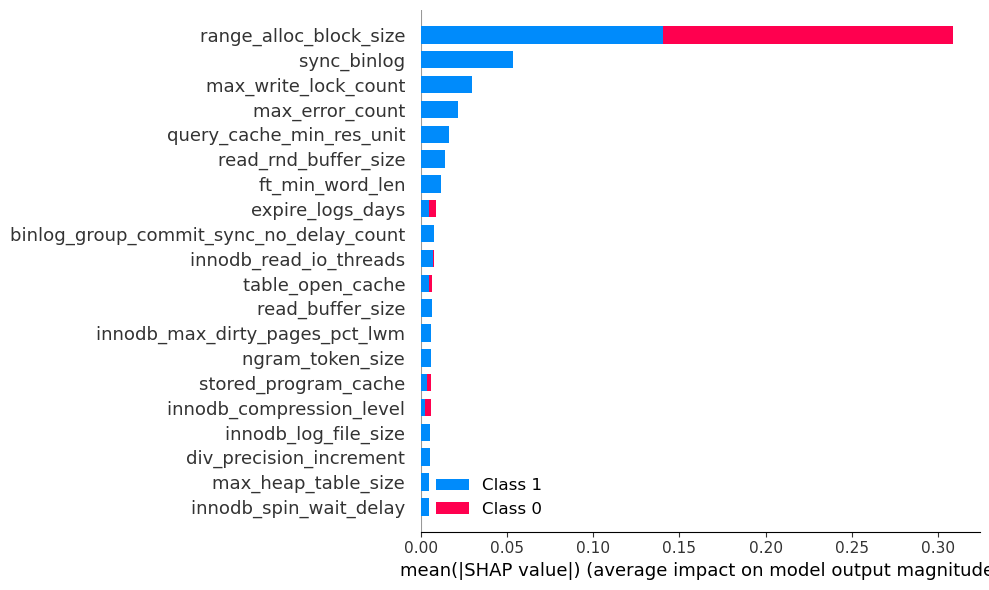

In [290]:
####
import plotly.graph_objs as go

fig = shap.summary_plot(shap_values, scaled_X_test, plot_type="bar" , feature_names=shap_x.columns, plot_size=[10,6] )


In [291]:
# shap_values.sort(reverse=True)
tps_shap_values = pd.DataFrame(shap_values[0])
latency_shap_values = pd.DataFrame(shap_values[1])

tps_shap_values.columns = shap_x.columns
latency_shap_values.columns = shap_x.columns
# latency_shap_values

In [ ]:
### tps 순서대로 config 출력

#### About Throuthput

# 데이터프레임을 넘파이로
shap_tps_np = np.array(tps_shap_values)

# array의 값을 절댓값으로 반환
shap_tps_np = np.abs(shap_tps_np)

# axis=0 기준으로 평균값 계산
shap_tps_mean = np.mean(shap_tps_np, 0)

# sorting index 반환
sorted_index_tps = shap_tps_mean.argsort()[::-1]

tps_index = []
for ind in sorted_index_tps:
    print(tps_shap_values.columns[ind])
    tps_index.append(tps_shap_values.columns[ind])

In [293]:
tps_index

['range_alloc_block_size ',
 'expire_logs_days ',
 'innodb_compression_level ',
 'innodb_log_buffer_size ',
 'stored_program_cache ',
 'table_open_cache ',
 'default_week_format ',
 'innodb_rollback_segments ',
 'net_write_timeout ',
 'innodb_io_capacity_max ',
 'automatic_sp_privileges ',
 'innodb_read_io_threads ',
 'innodb_table_locks ',
 'innodb_adaptive_max_sleep_delay ',
 'transaction_prealloc_size ',
 'innodb_deadlock_detect ',
 'back_log ',
 'group_concat_max_len ',
 'binlog_cache_size ',
 'innodb_ft_total_cache_size ',
 'transaction_alloc_block_size ',
 'eq_range_index_dive_limit ',
 'binlog_group_commit_sync_no_delay_count ',
 'query_prealloc_size ',
 'binlog_rows_query_log_events ',
 'innodb_max_purge_lag_delay ',
 'max_digest_length ',
 'key_cache_age_threshold ',
 'innodb_disable_sort_file_cache ',
 'max_points_in_geometry ',
 'innodb_compression_pad_pct_max ',
 'innodb_lru_scan_depth ',
 'innodb_write_io_threads ',
 'max_binlog_stmt_cache_size ',
 'innodb_flush_sync ',
 '

In [ ]:
#### About Latency

# 데이터프레임을 넘파이로
shap_la_np = np.array(latency_shap_values)

# array의 값을 절댓값으로 반환
shap_la_np = np.abs(shap_la_np)

# axis=0 기준으로 평균값 계산
shap_la_mean = np.mean(shap_la_np, 0)

# sorting index 반환
sorted_index_la = shap_la_mean.argsort()[::-1]

latency_index = []
for ind in sorted_index_la:
    print(latency_shap_values.columns[ind])
    latency_index.append(latency_shap_values.columns[ind])

In [295]:
len(latency_index)

139

In [ ]:
all_knob_list = list(concat_all_df.columns)
all_knob_list

In [302]:
import numpy as np
latency_score = dict(zip(latency_index,np.arange(len(latency_index))))
tps_score = dict(zip(tps_index,np.arange(len(tps_index))))
total_score = dict(zip(knob_list, score_list))

knob_list = []
score_list = []
for col in all_knob_list:
    score= latency_score[col]+tps_score[col]
    # print("{} KNOB SCORE : ".format(col), score)
    knob_list.append(col)
    score_list.append(score)
    
    

In [231]:
total_score.values()

dict_values([214, 113, 131, 120, 135, 269, 81, 121, 142, 121, 225, 84, 32, 205, 154, 197, 59, 167, 176, 160, 130, 57, 68, 146, 246, 159, 116, 76, 147, 159, 113, 205, 197, 189, 167, 174, 195, 214, 68, 159, 133, 143, 179, 145, 81, 69, 160, 189, 65, 29, 39, 145, 143, 69, 19, 149, 65, 73, 262, 159, 149, 93, 126, 129, 240, 76, 194, 152, 210, 54, 105, 149, 245, 226, 226, 215, 69, 252, 92, 108, 148, 143, 179, 128, 207, 77, 59, 200, 265, 101, 226, 153, 228, 180, 74, 139, 79, 74, 118, 146, 162, 52, 78, 174, 132, 104, 105, 92, 51, 162, 177, 176, 254, 155, 115, 107, 32, 193, 44, 201, 60, 113, 39, 100, 252, 189, 166, 228, 92, 28, 165, 103, 100, 110, 69, 115, 135, 98, 213])

In [232]:
total_score

{'automatic_sp_privileges ': 214,
 'back_log ': 113,
 'binlog_cache_size ': 131,
 'binlog_group_commit_sync_delay ': 120,
 'binlog_group_commit_sync_no_delay_count ': 135,
 'binlog_rows_query_log_events ': 269,
 'binlog_stmt_cache_size ': 81,
 'bulk_insert_buffer_size ': 121,
 'default_week_format ': 142,
 'div_precision_increment ': 121,
 'end_markers_in_json ': 225,
 'eq_range_index_dive_limit ': 84,
 'expire_logs_days ': 32,
 'explicit_defaults_for_timestamp ': 205,
 'flush_time ': 154,
 'ft_min_word_len ': 197,
 'ft_query_expansion_limit ': 59,
 'general_log ': 167,
 'group_concat_max_len ': 176,
 'innodb_adaptive_hash_index_parts ': 160,
 'innodb_adaptive_max_sleep_delay ': 130,
 'innodb_autoextend_increment ': 57,
 'innodb_buffer_pool_size ': 68,
 'innodb_change_buffer_max_size ': 146,
 'innodb_cmp_per_index_enabled ': 246,
 'innodb_commit_concurrency ': 159,
 'innodb_compression_failure_threshold_pct ': 116,
 'innodb_compression_level ': 76,
 'innodb_compression_pad_pct_max ': 1

In [303]:
print(sorted(total_score.items(), key=lambda x:x[1]))
print(dict(sorted(total_score.items(), key=lambda x:x[1])))
top_rank = sorted(total_score,key=lambda x:total_score[x])

[('range_alloc_block_size ', 0), ('expire_logs_days ', 17), ('innodb_read_io_threads ', 19), ('table_open_cache ', 19), ('stored_program_cache ', 24), ('binlog_group_commit_sync_no_delay_count ', 29), ('innodb_compression_level ', 29), ('innodb_log_buffer_size ', 34), ('back_log ', 37), ('eq_range_index_dive_limit ', 40), ('read_buffer_size ', 45), ('ngram_token_size ', 48), ('innodb_deadlock_detect ', 49), ('innodb_io_capacity_max ', 51), ('automatic_sp_privileges ', 53), ('innodb_max_purge_lag_delay ', 54), ('transaction_alloc_block_size ', 56), ('binlog_cache_size ', 58), ('net_write_timeout ', 58), ('innodb_rollback_segments ', 60), ('innodb_ft_total_cache_size ', 68), ('max_error_count ', 68), ('innodb_max_purge_lag ', 73), ('read_rnd_buffer_size ', 73), ('div_precision_increment ', 75), ('group_concat_max_len ', 82), ('innodb_adaptive_max_sleep_delay ', 83), ('query_prealloc_size ', 83), ('innodb_lru_scan_depth ', 86), ('innodb_buffer_pool_size ', 88), ('ft_query_expansion_limit 

In [ ]:
top_rank

In [235]:
top_20_config = top_rank[:20]

In [304]:
top_10_config = top_rank[:10]

In [305]:
top_10_config

['range_alloc_block_size ',
 'expire_logs_days ',
 'innodb_read_io_threads ',
 'table_open_cache ',
 'stored_program_cache ',
 'binlog_group_commit_sync_no_delay_count ',
 'innodb_compression_level ',
 'innodb_log_buffer_size ',
 'back_log ',
 'eq_range_index_dive_limit ']

### Top-k knob에 대한 실험

In [338]:
###XGBRegressor top_10_knob을 가진 config에 대해서 (config 내에 성능 좋은 knob 10개)
### Y는 어찌해야하는지? // Y도 똑같음

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

top_10_config_all= concat_all_df[top_10_config]
# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(top_10_config_all)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)

###top_10_config

### Top Config 내에 Top-k knob에 대한 실험

In [350]:
###XGBRegressor top_10_knob을 가진 config에 대해서 (config 내에 성능 좋은 knob 10개)
###config Top-10개 내에 Top-10개 knob

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

top_10_config_all= concat_all_df[top_10_config]
top_10_config_with_top_knob = best_all_df[top_10_config]
# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(top_10_config_with_top_knob)
Y_all = np.array(metrics[['tps', 'latency']])
Y_top_10 = Y_all[:10]

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_top_10)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)

###top_10_config

### 공통 / excel 파일 명 확인

In [351]:
class SMAC(object):
    def __init__(self, iteration, model, config_info_path=None):
        self.iteration = iteration
        self.my_model = model
        self.config_info_path = config_info_path
        
        self._get_config_info()
        self._get_scenario_path_name()
        self._init_configuration()
            
    
    def _get_scenario_path_name(self):
        i = 0
        date_str = datetime.today().strftime("%Y%m%d")
        name = date_str + '-' + '%02d'%i
        while os.path.isdir(os.path.join('smac3_output', name)):
            i += 1
            name = date_str + '-' + '%02d'%i
        self.scenario_name = name
        print("#########################################################")
        print("Scenario data will saved in ", os.path.join('smac3_output', self.scenario_name))
        print("#########################################################\n")
    
    def _get_config_info(self):
        if self.config_info_path is None:
            self.config_info = pd.read_csv('/home/sein/2023_EDBT/config_last_tpcc_top10.csv', index_col=0)
        else:
            self.config_info = pd.read_csv(self.config_info_path, index_col=0)

      
    
    def _get_history(self):
        self.history_configs = self.smac.runhistory.get_configs()
    
    def _init_configuration(self):
        self.cs = ConfigurationSpace()
        
        ## Build Configuriation Generator
        hyps = []
        for name in self.config_info.index:
            knob = self.config_info.loc[name]
            # knob = self.config_info[name]
            
            if knob['type'] == 'boolean' or knob['type'] == 'integer':
                if knob['default'] > knob['max_64mb']:
                    ## If default is larger than max_64mb, then use median of min and max_64mb as default
                    tmp_def = (knob['min'] + knob['max_64mb'].astype(int)) // 2
                else:
                    tmp_def = knob['default']
                hyps.append(UniformIntegerHyperparameter(name=str(name), lower=int(knob['min']), upper=int(knob['max_64mb']), default_value=tmp_def.astype(int)))
            elif knob['type'] == 'float':
                hyps.append(UniformFloatHyperparameter(name=str(name), lower=knob['min'], upper=knob['max_64mb'], default_value=knob['default']))
        self.cs.add_hyperparameters(hyps)
        
        self.scenario = Scenario(self.cs, deterministic=True, n_trials=self.iteration, name=self.scenario_name)
    
    def _target_function(self, config: Configuration, seed: int = 0) -> float:
        X = pd.DataFrame(config.get_dictionary().values(), index=self.config_info.index).T
        ## scaled_X = X.values
        ## scaled_X = Scaler.transform(X)
        ## res = regression_model(scaled_X)
        pred = self.my_model.predict(X)
        for ii in range(len(pred)):
            res = pred[ii][1] / pred[ii][0]
        return res # a smaller result means better
    
    
    def tune(self):
        '''
            After smac.optimize(), the history data are saved in output_dir: 'smac3_output'
        '''
        self.smac = HyperparameterOptimizationFacade(scenario=self.scenario, target_function=self._target_function)
        self.incumbent = self.smac.optimize() #minimize
    
    def plot_history(self):
        self._get_history()
        
#         res = []
        self.his_inc = []
        inc = np.inf
        ## Get minimum results on each iteration
        for his_cfg in self.history_configs:
            his_res = self.smac.validate(his_cfg)
            if his_res < inc:
                inc = his_res
            self.his_inc.append(inc)
#             res.append(his_res)

        plt.plot(self.his_inc)
        plt.xlabel('Iteration')
        plt.ylabel('result')
        plt.show()

In [357]:
tuner = SMAC(iteration=200, model=my_model)
tuner.tune()

#########################################################
Scenario data will saved in  smac3_output/20230427-36
#########################################################

[INFO][abstract_initial_design.py:82] Reducing the number of initial configurations from 100 to 50 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:134] Using 50 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:513] Added config 2cd73b as new incumbent because there are no incumbents yet.
[INFO][smbo.py:298] Finished 50 trials.
[INFO][smbo.py:298] Finished 100 trials.
[INFO][smbo.py:298] Finished 150 trials.
[INFO][smbo.py:298] Finished 200 trials.
[INFO][smbo.py:306] Configuration budget is exhausted:
[INFO][smbo.py:307] --- Remaining wallclock time: inf
[INFO][smbo.py:308] --- Remaining cpu time: inf
[INFO][smbo.py:309] --- Remaining trials: 0


In [359]:
new_config = tuner.smac.runhistory.get_configs()
new_config

[Configuration(values={
   'binlog_group_commit_sync_delay': 266878,
   'innodb_adaptive_max_sleep_delay': 620565,
   'innodb_ft_result_cache_limit': 8107224,
   'innodb_io_capacity_max': 21256,
   'innodb_lru_scan_depth': 57803552,
   'max_digest_length': 519586,
   'max_heap_table_size': 64423522,
   'max_prepared_stmt_count': 1045201,
   'max_seeks_for_key': 51817127,
   'transaction_prealloc_size': 93799,
 }),
 Configuration(values={
   'binlog_group_commit_sync_delay': 761236,
   'innodb_adaptive_max_sleep_delay': 268056,
   'innodb_ft_result_cache_limit': 63032976,
   'innodb_io_capacity_max': 95809,
   'innodb_lru_scan_depth': 21466928,
   'max_digest_length': 580661,
   'max_heap_table_size': 12373038,
   'max_prepared_stmt_count': 155942,
   'max_seeks_for_key': 28448221,
   'transaction_prealloc_size': 15810,
 }),
 Configuration(values={
   'binlog_group_commit_sync_delay': 548897,
   'innodb_adaptive_max_sleep_delay': 943590,
   'innodb_ft_result_cache_limit': 30533263,
   '

In [360]:
### 성능 best
best_config_smac = tuner.incumbent
best_config_smac

Configuration(values={
  'binlog_group_commit_sync_delay': 266878,
  'innodb_adaptive_max_sleep_delay': 620565,
  'innodb_ft_result_cache_limit': 8107224,
  'innodb_io_capacity_max': 21256,
  'innodb_lru_scan_depth': 57803552,
  'max_digest_length': 519586,
  'max_heap_table_size': 64423522,
  'max_prepared_stmt_count': 1045201,
  'max_seeks_for_key': 51817127,
  'transaction_prealloc_size': 93799,
})

In [361]:
import configparser as cp

def make_mysql_conf_file(configuration: Configuration, path:str = None):
    '''
        To convert Configuration type to mysql config file
            my_test.cnf
    '''
    if path is None:
        # cnf_file = 'my_test_ycsb_top10_knob{}.cnf'.format(num)
        cnf_file = '[tpcc]CnK_top_10_200iter.cnf'
        
    else:
        cnf_file = path
    
    if os.path.exists(cnf_file) is False:
        f = open(cnf_file, "w")
        f.write("[mysqld]")
        f.close()
    
    config_parser = cp.ConfigParser()
    config_parser.read(cnf_file)
    config_parser.set('mysqld', 'log-error', '/var/log/mysqld.log')
    config_parser.set('mysqld', 'bind-address', '127.0.0.1')  
    config_parser.set('mysqld', 'basedir', '/usr/local/mysql')
    config_parser.set('mysqld', 'datadir', '/usr/local/mysql/data')
    
    for k, v in configuration.items():
        config_parser.set('mysqld', k, str(v))

    config_parser.write(open(cnf_file, 'w'))

In [362]:
# for num in range(len(new_config)):
#     make_mysql_conf_file(new_config[num])

make_mysql_conf_file(best_config_smac)

### config 중에서 성능이 좋은 best_config 뽑기

In [26]:
###성능 좋은 best_config 10개 뽑기

metrics['score'] = metrics['tps'] / metrics['latency']

metrics_list_sorting = metrics.sort_values('score', ascending=False)

best_config = metrics_list_sorting.head(10)
best_config
# random_metric_list.head(10)

,tps,latency,score
91,446.815280,13151,3.397576e-02
97,442.744854,13185,3.357944e-02
71,417.011060,14406,2.894704e-02
85,391.881830,15401,2.544522e-02
44,432.949269,17592,2.461058e-02
6,421.545924,17211,2.449282e-02
45,364.797840,23593,1.546212e-02
84,0.133331,1063769,1.253384e-07
26,0.049999,1087481,4.597713e-08
17,0.049999,1103031,4.532902e-08
